# 1. Preprocessing
# 2. Call Pretrained Models
# 3. Training and Testing Functions
# 4. Hyperparamter Optimization with Optuna
# 5. Post-Processing and Performance Evaluation

## Intro
- In Part-1 of this notebook, I built a model from scratch. Here in Part-2, we will focus on transfer learning with five pretrained models resnet18,alexnet,vgg11,squeezenet1.0 and densenet121.
- Again Optuna is the backbone of the training stages. I excluded some functions used in the first notebook as they are essentially the same. Here is the thought process;

1. I first followed the simples strategy; get model and freeze all the layers, replace the classification head of each model accordingly and thus train only the last two fully connected layer. I perfomed 20 studies with 10 epochs to pick the best model. Across these trials, Squeezenet1 achived the top 7 highest overal accuracy with **81%** being the highest one.
2. I then picked Squeezenet with the best parameters suggested by Optuna and trained it 150 epochs. The result is **86%** overal accuracy. 
3. Note that Squeezenet is a decent model with around 740K parameters in this problem. With the freezing, we essentially look at 10K trainable paramaters out of those 740K. With that in mind, I turn off the freezing and trained the full model with 150 epochs. Notice that another approch would be to add more layers to modified classification head. You can give it a try. 
- The final scores for the final model are as follows **overal_acc: 93%, mean_recall = 93%, mean_precison = 92%, mean_f1 = 92%** 

In [1]:
#modify this cell accordingly if you use google-colab. Always upload the zip folders to your drive then unzip
# them to local colab directory. Otherwise, uploading thousands of images takes hours as opposed to minutes. Also,
# training will be ridiculous slow if you try to fetch the images from your drive during training. 
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/ColabNotebooks/ImageClassification'
    data_dir = root_dir + '/simpsons_dataset'
    !unzip '/content/drive/MyDrive/ColabNotebooks/ImageClassification/simpsons_dataset/test.zip' -d '/content/sample_data'
    !unzip '/content/drive/MyDrive/ColabNotebooks/ImageClassification/simpsons_dataset/train.zip' -d '/content/sample_data'
    train_dir = '/content/sample_data/train'
    test_dir = '/content/sample_data/test'
    ext_dir =  root_dir + '/Results'
    #add your modules here.
    !pip install optuna
    !pip install -U git+https://github.com/albumentations-team/albumentations    

In [2]:
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import albumentations as A  
from albumentations.pytorch import ToTensorV2
#===========================#
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch import optim
import optuna
#============================#
import os
import time
import random
import joblib
import sys
import shutil
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore') 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
#==============================#
%matplotlib inline

NVIDIA GeForce RTX 3080 Laptop GPU


# 1. Prepare the Data

In [3]:
data_dir='simpsons_dataset_resized/'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
ext_dir =  'Results/'
    

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
def GetDataPaths(train_dir,test_dir):
    class_list = []
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):

        if len(dirnames)!=0:
            class_list = dirnames
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath,names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath,names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)
    
    return train_image_paths,test_image_paths,class_list

train_image_paths,test_image_paths,class_list = GetDataPaths(train_dir, test_dir)
num_classes = len(class_list)
idx_to_class = {i:j for i, j in enumerate(class_list)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

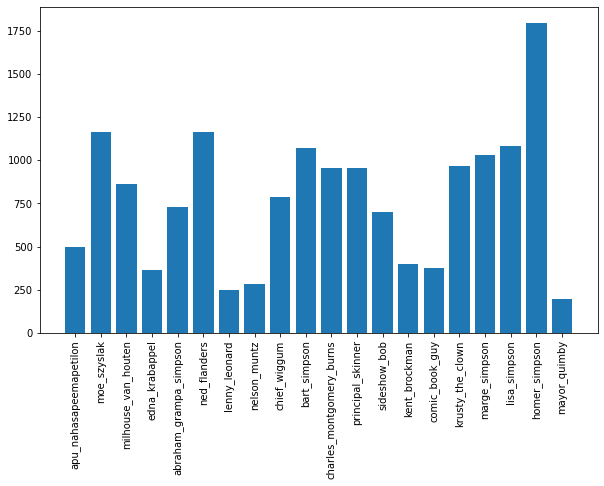

In [6]:
def ShowClassDist(train_dir):
    class_counts = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        if len(filenames)>0:
            class_counts.append(len(filenames))

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(class_list, class_counts)
    plt.xticks(fontsize=10, rotation=90)
    plt.show()
ShowClassDist(train_dir)

In [7]:
class SimpsonsDataset(Dataset):
    def __init__(self, image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath).convert("RGB")
        
        
        #class name and tag
        label = image_filepath.split('/')[-2] 
        label = class_to_idx[label]
        if self.transform is not None:
            img = self.transform(image=np.array(img))["image"]
        else:
            tfm = ToTensorV2()
            img = tfm(image = np.array(img))["image"]
            
        
        return img, label


In [8]:
def GetSampleWeights(train_image_paths):
    class_weights = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        if len(filenames)>0:
            class_weights.append(1000.*1/len(filenames))

    sample_weights = [0]*len(train_image_paths)
    for i in range(len(train_image_paths)):
        label = train_image_paths[i].split('/')[-2]
        class_weight = class_weights[class_to_idx[label]]
        sample_weights[i] = class_weight
        
    return sample_weights,torch.FloatTensor(class_weights).to(device)

sample_weights,class_weights = GetSampleWeights(train_image_paths)

In [9]:
def GetLoaders(train_batch_size,test_batch_size):
    mean = [0.485, 0.456, 0.406]
    std =  [0.229, 0.224, 0.225]
    training_transforms = A.Compose([A.HorizontalFlip(p=0.5),
                                     A.VerticalFlip(p=0.5),
                                     A.GaussianBlur(p=0.2),
                                     A.Normalize(mean,std),
                                     ToTensorV2()])
    
    test_transforms = A.Compose([A.Normalize(mean,std),
                                        ToTensorV2()])
    
    train_set = SimpsonsDataset(train_image_paths, transform = training_transforms)
    
    
    #sample_weights,_ = GetSampleWeights(train_image_paths)
    #sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights),replacement=True)
    train_loader = DataLoader(train_set, batch_size = train_batch_size,shuffle=True,drop_last=True )
    
    test_set  = SimpsonsDataset(test_image_paths, transform = test_transforms)
    test_loader  = DataLoader(test_set, batch_size = test_batch_size,drop_last=True)

    
    return train_loader, test_loader

# 2. Call Pretrained Models

The following function is from Pytorch's official website [here](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html). It returns pretrained models with modified classification head. They all except 244x224 images.

In [10]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def GetModel(model_name, num_classes=num_classes, feature_extract=True, use_pretrained=True):
    model_ft = None
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
       

    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
       
    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
       

    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        

    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [11]:
model = GetModel(model_name = 'squeezenet').to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

# 3. Training and Testing Functions

In [12]:
def TrainModel(trial, model, train_loader, optimizer,epoch,log_int):
   
    # set to train mode
    model.train()
    model.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # compute the train loss and correct predictions per epoch
    train_loss = 0.0
    total_train_correct = 0
    
    
    for i,(inputs, targets) in enumerate(tqdm(train_loader,desc=f'training{epoch}')):
        torch.cuda.empty_cache()
        inputs = inputs.to(device)
        targets = targets.to(device)
        

        #In default, pytorch accumulates the gradient, zero out before each backpropagation.
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # compute the loss
        loss = criterion(outputs, targets)

        # backpropagate the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # compute the predictions
        predictions = outputs.argmax(dim=1)

        # boolen compare the predictions vs targets
        correct_counts = predictions.eq(targets)

        # accumulate the total train correct and update over the batches.
        total_train_correct += correct_counts.sum().item()


    # training loss and training accuracy
    avg_train_loss = train_loss/len(train_loader.dataset) 
    avg_train_acc = total_train_correct/float(len(train_loader.dataset))
    if epoch%log_int==0:
        print(f'train_loss: {avg_train_loss:0.5f} train_acc: {avg_train_acc:0.2f}')
    
    trial.report(avg_train_acc,epoch)
    if trial.should_prune():
        print(f'Pruned when acc:{avg_train_acc:0.4f} epoch: {epoch}\n')
        raise optuna.TrialPruned()
    
    return avg_train_acc

In [13]:
def TestModel(model, test_loader,epoch,log_int):
    # For testing, no need to track gradients. 
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.
    total_test_correct = 0
    with torch.no_grad():
        for j,(inputs, targets) in enumerate(tqdm(test_loader,desc='testing')):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = model(inputs)

            # compute the loss
            loss = criterion(outputs, targets)

            # compute the loss for the batch and add it to total test_loss
            test_loss += loss.item() * inputs.size(0)

            # compute the predictions
            predictions = outputs.argmax(dim=1)

            # boolen compare the predictions vs labels
            correct_counts = predictions.eq(targets)

            # accumulate the total test correct over the batches.
            total_test_correct += correct_counts.sum().item()
            
    # test loss and test accuracy
    avg_test_loss = test_loss/len(test_loader.dataset) 
    avg_test_acc = total_test_correct/float(len(test_loader.dataset))
    if epoch%log_int==0:
        print(f'test_loss: {avg_test_loss:0.4f} test_acc: {avg_test_acc:0.2f}\n')

    return avg_test_acc

In [14]:
def GetStudyDataFrame(study = optuna.study.Study,name='StudyDataFrame',
                      drop_info = ['state','datetime_start','datetime_complete'],
                      save = True):
    df_study = study.trials_dataframe().drop(drop_info, axis=1)
    x = []
    for i in range(len(df_study)):
        mins = round(df_study['duration'][i].seconds/60,ndigits=2)
        x.append(mins)
    df_study['duration'] = x
    df_study = df_study.sort_values(by='value',ascending=False)
    if save:
        path = ext_dir +'/'+ name +'.csv'
        df_study.to_csv(path,index=False)
    
    return df_study

In [15]:
def SaveModel(model,optimizer, name,beststats):
    checkpoint = { 'state_dict':  model.state_dict(),
                   'optim_state': optimizer.state_dict(),
                   'best_stats':  beststats
                 }
    path = ext_dir + "/" + name + ".pth"
    torch.save(checkpoint, path )

In [16]:
def LoadModel(model,filepath,train_mode = False):
    #load the model and assign the pre-trained weights
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    
    #if train required
    if train_mode:        
        for parameter in model.parameters():
            parameter.requires_grad = False
        optimizer.load_state_dict(checkpoint['optim_state'])
        
        return model,optimizer
    
    else:
        return model

# 4. Hyperparamter Optimization with Optuna

In [17]:
#this is the final configuration. Look below for the used parameters of the previous studies.
def SuggestParams(trial):
    cfg = {#"model_name": trial.suggest_categorical('model_name',["resnet","alexnet", "vgg","squeezenet", "densenet"]),
        'model_name': trial.suggest_categorical('model_name',["squeezenet"]), 
        'train_batch_size' : trial.suggest_int('train_batch_size',35,35),
          'lr' : trial.suggest_float('lr', 0.0006846, 0.0006846),
          'optimizer': trial.suggest_categorical('optimizer',[optim.Adam]),
        }

    return cfg

In [18]:
scores = [0.]
def objective(trial):
    max_acc = 0.
    cfg = SuggestParams(trial)

    train_loader, test_loader = GetLoaders(cfg['train_batch_size'], test_batch_size = 36)
    model = GetModel(cfg["model_name"])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'],)
    print(f'Trial:{trial.number} Training {cfg["model_name"]}....\n')

    num_epochs = 150
    for epoch in range(num_epochs + 1):
        train_acc = TrainModel(trial,model, train_loader, optimizer,epoch,log_int=20)
        test_accuracy = TestModel(model,test_loader,epoch,log_int=20)
        
        if test_accuracy > max_acc:
            max_acc = test_accuracy

    if max(scores) < max_acc:
        beststats = {'BestAcc':     max_acc ,  
                    'lr':           cfg['lr'],
                    'batch_size':   cfg['train_batch_size'],
                  }
        #save the best model
        SaveModel(model,optimizer,'best_model',beststats)
    
    #register all the scores from each trial globally
    scores.append(max_acc)
        
    return test_accuracy

In [19]:
def StartStudy(study_name = 'SimsStudy',sampler = optuna.samplers.TPESampler(),n_trials=1,n_jobs=1):
    
    pruner = optuna.pruners.MedianPruner(n_startup_trials=3,n_warmup_steps=30)
    study = optuna.create_study(study_name=study_name,sampler=sampler, pruner=pruner,direction='maximize')
    study.optimize(func=objective, n_trials=n_trials, n_jobs=n_jobs)
    path = ext_dir + "/" + study_name + '.pkl' 
    joblib.dump(study, path)
    GetStudyDataFrame(study=study, name = study_name)
    
    return study

In [20]:
# cfg = {"model_name": trial.suggest_categorical('model_name',["resnet","alexnet", "vgg","squeezenet", "densenet"]),
#     'train_batch_size' : trial.suggest_int('train_batch_size',24,48),
#   'lr' : trial.suggest_float('lr', 1e-4, 1e-3),
#   'optimizer': trial.suggest_categorical('optimizer',[optim.Adam]),
# }
# Let's pick the best model over 10 epochs. Then we will train the best one more epochs with the best paramaters
#study1 = StartStudy(study_name = 'SimsStudy1',n_trials = 24)

In [21]:
df1 = pd.read_csv(ext_dir+'SimsStudy1.csv')
display(df1)
print(f'train_time: {df1["duration"].sum()/60:0.2f} hours')

number     value  duration  params_lr params_model_name  \
0       19  0.816280      7.77   0.000685        squeezenet   
1       23  0.806328      9.20   0.000774        squeezenet   
2       21  0.802501      7.72   0.000676        squeezenet   
3       22  0.802245      8.37   0.000711        squeezenet   
4       18  0.799183      7.73   0.000456        squeezenet   
5       17  0.792039      7.75   0.000414        squeezenet   
6       16  0.790763      7.73   0.000406        squeezenet   
7       13  0.783873      7.68   0.000278        squeezenet   
8       12  0.773156     12.80   0.000297          densenet   
9       11  0.772136     12.83   0.000343          densenet   
10       9  0.771625     12.93   0.000329          densenet   
11      14  0.763715      7.67   0.000237        squeezenet   
12      15  0.762184      7.65   0.000211        squeezenet   
13      10  0.761929     12.80   0.000356          densenet   
14       1  0.746619     12.87   0.000153          densenet   
15       6  0.717020      7.60   0.000765            resnet   
16       2  0.710130      7.88   0.000675            resnet   
17       5  0.708599      7.67   0.000517            resnet   
18       8  0.698137      7.58   0.000595            resnet   
19       4  0.672876     13.05   0.000876               vgg   
20       3  0.669048      6.20   0.000545           alexnet   
21       0  0.664200      7.72   0.000101            resnet   
22       7  0.660373     13.00   0.000458               vgg   
23      20  0.633835      6.58   0.000907           alexnet   

                   params_optimizer  params_train_batch_size  
0   <class 'torch.optim.adam.Adam'>                       35  
1   <class 'torch.optim.adam.Adam'>                       40  
2   <class 'torch.optim.adam.Adam'>                       38  
3   <class 'torch.optim.adam.Adam'>                       39  
4   <class 'torch.optim.adam.Adam'>                       37  
5   <class 'torch.optim.adam.Adam'>                       37  
6   <class 'torch.optim.adam.Adam'>                       38  
7   <class 'torch.optim.adam.Adam'>                       42  
8   <class 'torch.optim.adam.Adam'>                       48  
9   <class 'torch.optim.adam.Adam'>                       48  
10  <class 'torch.optim.adam.Adam'>                       46  
11  <class 'torch.optim.adam.Adam'>                       42  
12  <class 'torch.optim.adam.Adam'>                       43  
13  <class 'torch.optim.adam.Adam'>                       48  
14  <class 'torch.optim.adam.Adam'>                       32  
15  <class 'torch.optim.adam.Adam'>                       39  
16  <class 'torch.optim.adam.Adam'>                       35  
17  <class 'torch.optim.adam.Adam'>                       26  
18  <class 'torch.optim.adam.Adam'>                       41  
19  <class 'torch.optim.adam.Adam'>                       31  
20  <class 'torch.optim.adam.Adam'>                       29  
21  <class 'torch.optim.adam.Adam'>                       29  
22  <class 'torch.optim.adam.Adam'>                       45  
23  <class 'torch.optim.adam.Adam'>                       34

train_time: 3.68 hours



Optuna provides several visualizations tools to further inspect the trials. Few of them are as follows;

In [22]:
study1 = joblib.load(ext_dir+'SimsStudy1.pkl')

In [23]:
study1.best_params

{'model_name': 'squeezenet',
 'train_batch_size': 35,
 'lr': 0.0006846837817179431,
 'optimizer': torch.optim.adam.Adam}

In [24]:
optuna.visualization.plot_param_importances(study1)

In [25]:
optuna.visualization.plot_parallel_coordinate(study1,params=['model_name','lr','train_batch_size'])

In [26]:
#based on your browser, you can hower on the figure.
optuna.visualization.plot_optimization_history(study1)

From the trials above, we will narrow down search to squeezenet and train more epochs with the optimal paramters detected above.

In [27]:
# cfg = {#"model_name": trial.suggest_categorical('model_name',["resnet","alexnet", "vgg","squeezenet", "densenet"]),
# 'model_name': trial.suggest_categorical('model_name',["squeezenet"]) 
# 'train_batch_size' : trial.suggest_int('train_batch_size',35,35),
#   'lr' : trial.suggest_float('lr', 0.0006846, 0.0006846),
#   'optimizer': trial.suggest_categorical('optimizer',[optim.Adam]),
# n_epochs=150
# }
#study = StartStudy(study_name = 'SimsStudy2',n_trials = 1)

In [28]:
df2 = pd.read_csv(ext_dir+'SimsStudy2.csv')
display(df2)
print(f'train_time: {df2["duration"].sum()/60:0.2f} hours')

number     value  duration  params_lr params_model_name  \
0       0  0.863996    100.97   0.000685        squeezenet   

                  params_optimizer  params_train_batch_size  
0  <class 'torch.optim.adam.Adam'>                       35

train_time: 1.68 hours


Lastly, we will train the full model with pretrained weights and the parameters found above.

In [29]:
#study3 = StartStudy(study_name = 'SimsStudy3',n_trials = 1,n_jobs=1)

In [30]:
df3 = pd.read_csv(ext_dir+'SimsStudy3.csv')
display(df3)
print(f'train_time: {df3["duration"].sum()/60:0.2f} hours')

number     value  duration  params_lr params_model_name  \
0       0  0.928553    134.27   0.000685        squeezenet   

                  params_optimizer  params_train_batch_size  
0  <class 'torch.optim.adam.Adam'>                       35

train_time: 2.24 hours


# 5. Post-Processing and Performance Evaluation
- Let's load the best model and inspect the results further.
- Functions below are hopefully self explanatory. If not, please let me know.

In [31]:
model = GetModel(model_name ='squeezenet')
model = LoadModel(model,'Results/best_model.pth')

In [32]:
_,test_loader = GetLoaders(1,32) 
TestModel(model,test_loader,1,1)

testing:   0%|          | 0/122 [00:00<?, ?it/s]

test_loss: 0.3080 test_acc: 0.93



0.932635876499107

In [33]:
#images for testing purposes. Do some work to get the right label. In the original testset, all 42 classes 
#are present. We need to filter only 20 of them we used in training.
def GetRawImageDir(testing_dir):
    raw_image_paths = []
    raw_image_labels = []
    for names in os.listdir(testing_dir):
        raw_image_paths.append(os.path.join(testing_dir,names))
    for i in range(len(raw_image_paths)):
        name = raw_image_paths[i].split('/')[-1]
        new_name = name.split('.')[-2]
        new_name = ''.join([j for j in new_name if not j.isdigit()])[:-1]
        if new_name in class_list:
            raw_image_labels.append(new_name)
    
    return raw_image_paths,raw_image_labels

raw_image_paths,raw_image_labels = GetRawImageDir('simpson_testset/')

In [34]:
@torch.no_grad()
def GetClassProbs(model,image_path,topk=3):
    model.to(device)
    model.eval()
    img = Image.open(image_path).convert("RGB")
    #label = image_path.split('/')[-2]
    mean = [0.485, 0.456, 0.406]
    std =  [0.229, 0.224, 0.225]
    tfm = A.Compose([A.Resize(224,224), A.Normalize(mean,std),ToTensorV2()])
    image = tfm(image = np.array(img))["image"]
    image = image.unsqueeze(0).to(device)
    output = model(image)
    probs = F.softmax(output)
    #get probabilities
    top_probabilities, top_indices = probs.topk(topk)
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [35]:
def ShowPredictions(raw_image_paths,raw_image_labels,n):
    plt.figure(figsize=(16, 4*n))
    for i in range(1,n+1):
        #display real character
        rnd_number = random.randint(0,len(raw_image_paths))
        img_path = raw_image_paths[rnd_number]
        label = raw_image_labels[rnd_number]
        image = Image.open(img_path).convert("RGB")
        image = image.resize((224,224))
        plt.subplot(n,3,3*i-2)
        plt.title(f'real: {label}')
        plt.imshow(image)
        #display probabilities
        top_probabilities, top_classes = GetClassProbs(model,img_path, topk=3)
        plt.subplot(n,3,3*i-1)
        plt.barh(top_classes, top_probabilities,align='center')
        #display predicted character
        real_class_dir = os.path.join(train_dir,top_classes[0])
        real_image_dir = os.path.join(real_class_dir,os.listdir(real_class_dir)[0])
        real_img = Image.open(real_image_dir).convert("RGB")
        plt.subplot(n,3,3*i)
        plt.title(f'pred: {top_classes[0]}')
        plt.imshow(real_img)
        plt.tight_layout()
    plt.show()

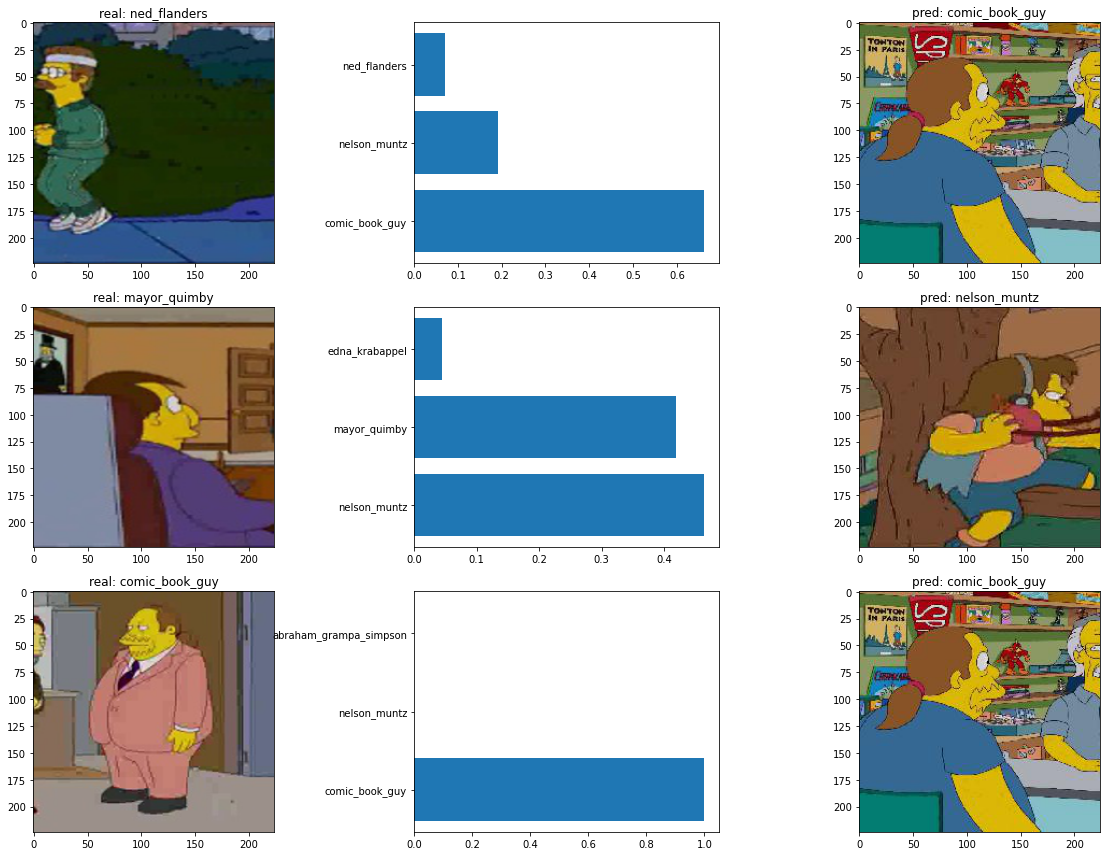

In [36]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

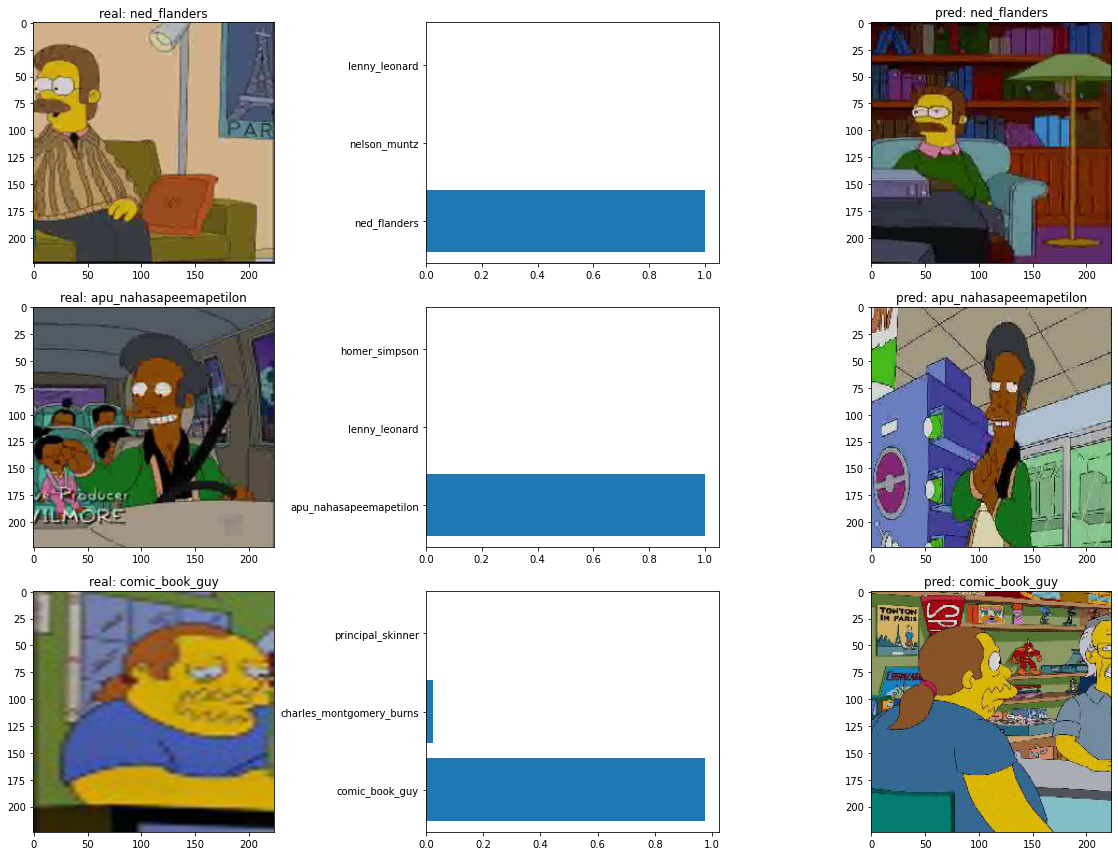

In [37]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

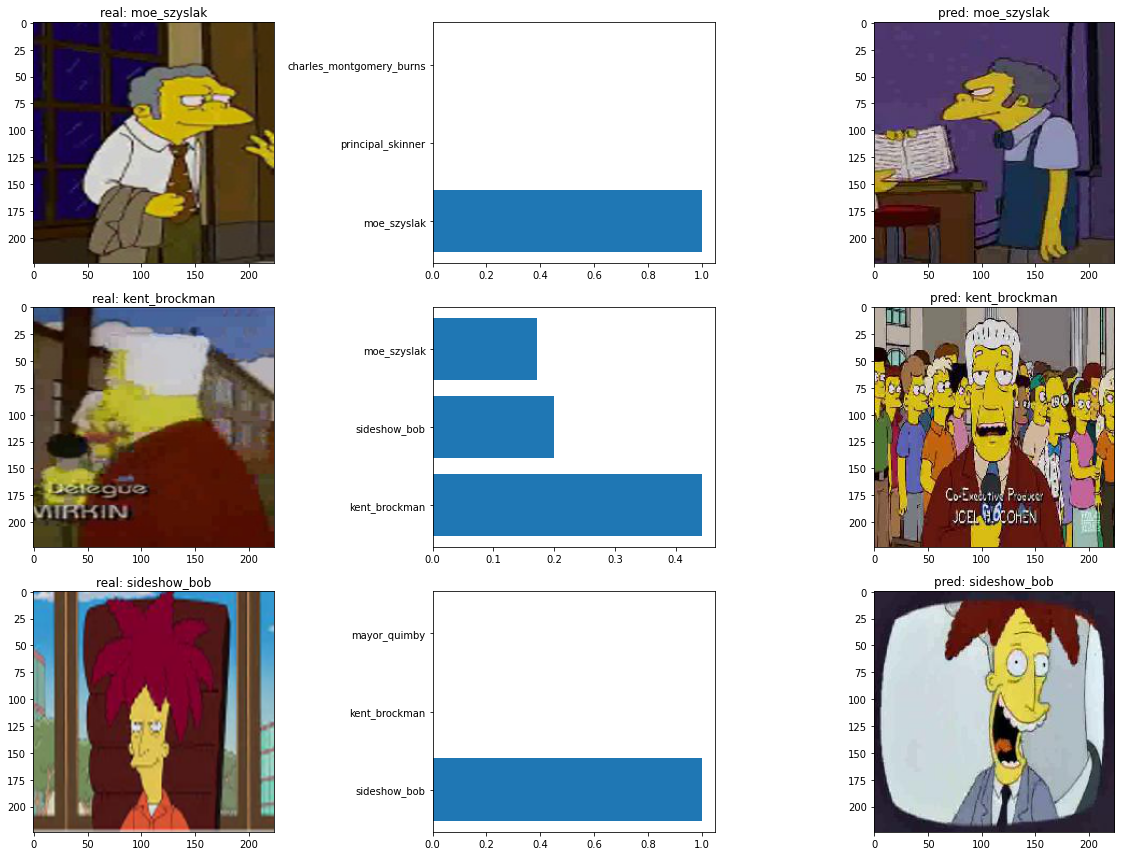

In [38]:
ShowPredictions(raw_image_paths,raw_image_labels,3)

In [39]:
def GetConfusionMatrix(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.to(device)
        all_preds  = torch.FloatTensor([]).to(device)
        all_labels = torch.LongTensor([]).to(device)
        #compute all predictions
        for batch in test_loader:
            images,labels = batch
            images,labels = images.to(device),labels.to(device)
            preds = model(images)
            all_preds = torch.cat(
                (all_preds,preds),
                dim=0
            )
            all_labels = torch.cat((all_labels,labels),dim=0)
        
        #get the predicted labels
        preds = all_preds.argmax(dim=1)
        #create confusion matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), preds.cpu().numpy())
        return cm
    

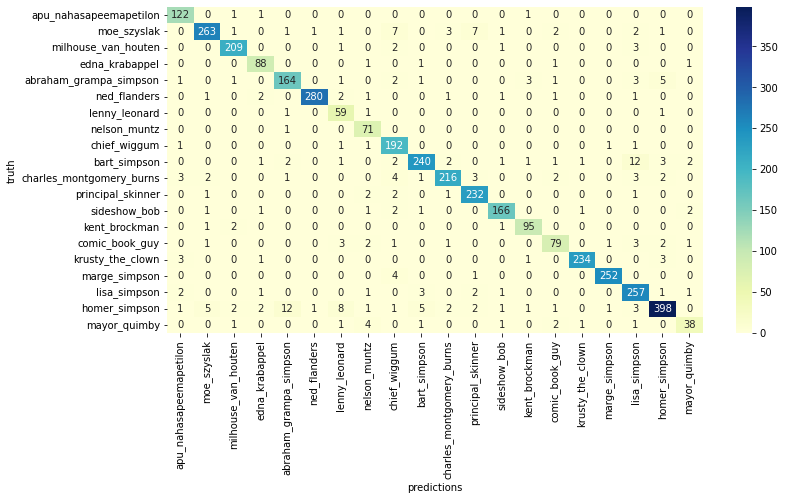

In [40]:
cm = GetConfusionMatrix(model,test_loader)
#display confusion matrix. truth:x_axis, preds:y_axis
df_cm = pd.DataFrame(cm, index = [i for i in class_list], columns = [i for i in class_list])
plt.figure(figsize=(12,6))
sns.heatmap(df_cm,annot=True,cmap="YlGnBu",fmt='g')
plt.xlabel('predictions')
plt.ylabel('truth')
plt.show()

## a. Overall Accuracy
Overal accuracy is important but it should be taken in caution as a high overal accuracy can be misleading.

In [41]:
OveralAcc = np.sum(np.diag(cm))/np.sum(cm)
print('overal_acc', OveralAcc)

overal_acc 0.936219262295082


In [42]:
def DisplayScores(class_list,scores,score_type = ''):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(class_list, scores)
    ax.bar_label(ax.containers[0],fmt='%.2f')
    ax.set_xticklabels(class_list, rotation=90)
    ax.set_title('mean_' + score_type +':'+ str(round(scores.mean(),ndigits=2)))
    plt.show()
    

## b. Recall
- Recall tells us the ability of algoritm to classify a particular class. 
- For example, we have 99 'kent_brockman' in testing set, sum of the 14th row. As we see above only 95 out of 99 is classified correctly. Out of 99, 4 images were classified other characters. Thus for kent_brockman is 95/99=0.96 
- Notice that for some tasks, we must prioritize this score. For example, if we want to label a video good/bad for students where bad videos rarely occur, high recall for 'bad 'is very important. One can afford classifying good as bad but the other way.

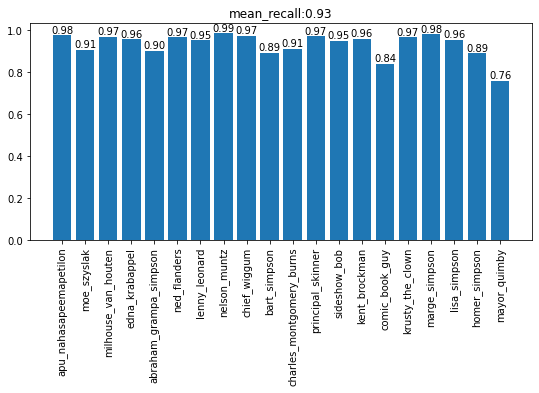

In [43]:
recalls = np.diag(cm)/np.sum(cm,axis = 1)
DisplayScores(class_list,recalls,'recall')

## c. Precision

- Precision for a class tells us the ability of an alg **not to label anything as that class**. 
- The 14th col above tells us 102 images are classified as 'kent_brockman' and 95 of them are correct. Thus precision for 'kent_brockman' is 95/102=0.93

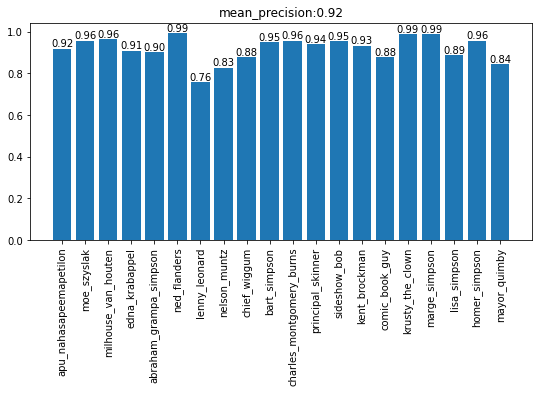

In [44]:
precisions = np.diag(cm)/np.sum(cm,axis = 0)
DisplayScores(class_list,precisions,'precision')

## d. F1-Score
This is the harmonic average of recall recall and precision. It is a realiable measure putting equal weigths on precison and recall. It sits somewhere between precision and recall. 

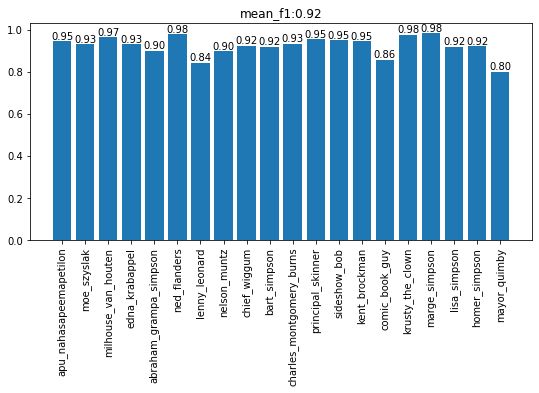

In [45]:
f1 = 2/(1/recalls + 1/precisions)
DisplayScores(class_list,f1,'f1')